In [1]:
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pylab as plt

from monteloanco import Model, Guide, GroupedBatchSampler

# Read data

In [2]:
df_jsonl = pd.read_json('accepted_2007_to_2018Q4.jsonl.gz', lines=True).set_index('id')

In [3]:
df = pd.read_csv('training.csv.gz', index_col='id')
df = df.join(df_jsonl, how='inner').reset_index()

In [4]:
df.pymnt = pd.Series([
    torch.tensor(a)[torch.tensor(b, dtype=torch.bool)]
    for a, b in zip(df.pymnt, df.train)
])

# Read model

In [5]:
device = 'cuda:0'

In [6]:
import pyro
pyro.get_param_store().load('param_store.pt')

/home/daniel/miniconda3/envs/pytorch/lib/python3.12/site-packages/pyro/params/param_store.py:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(input_file

In [7]:
model = Model(embedding_size=4, device=device)
model.load_state_dict(torch.load('model_params.pt', weights_only=True))

<All keys matched successfully>

In [8]:
guide = Guide(embedding_size=4, device=device)
guide.load_state_dict(torch.load('guide_params.pt', weights_only=True))

<All keys matched successfully>

# Perform test simulation

In [9]:
row = df.sample(1).squeeze()
print(row)
hidden_states, sim_pymnts, interst_payments, principal_payments = model.forward(
    batch_id=row.batch_id, 
    batch_idx=torch.tensor(row.batch_idx).repeat(100).to(device), 
    installments=torch.tensor(row.installment).repeat(100).to(device),
    loan_amnt=torch.tensor(row.loan_amnt).repeat(100).to(device), 
    int_rate=torch.tensor(row.int_rate).repeat(100).to(device))

id                                                     128018344
batch_idx                                                    184
batch_id                                                      22
loan_amnt                                                 6000.0
int_rate                                                    9.93
installment                                               193.41
score                                                   0.000134
score_prior                                            81.990639
pymnt          [tensor(194.6967), tensor(194.6967), tensor(19...
train          [True, True, True, True, True, True, True, Tru...
Name: 66302, dtype: object


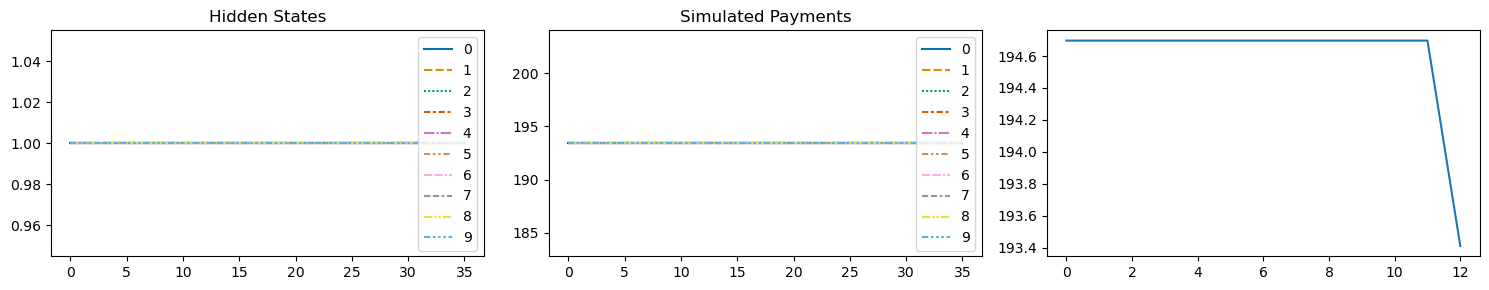

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.lineplot(hidden_states.cpu().detach().numpy()[:,:10], ax=ax[0], palette='colorblind')
sns.lineplot(sim_pymnts.cpu().detach().numpy()[:,:10], ax=ax[1], palette='colorblind')
sns.lineplot(row.pymnt.cpu(), ax=ax[2])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

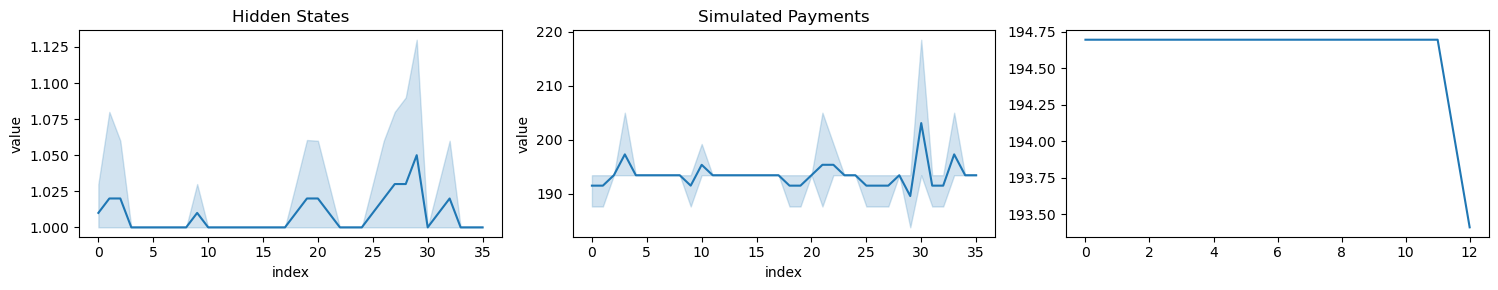

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
sns.lineplot(pd.DataFrame(hidden_states.cpu().detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[0])
sns.lineplot(pd.DataFrame(sim_pymnts.cpu().detach().numpy()).reset_index().melt(id_vars='index'), x='index', y='value', errorbar=('ci', 95), ax=ax[1])
sns.lineplot(row.pymnt.cpu(), ax=ax[2])
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

# Simulate full dataset

In [12]:
batch_size = 100_000
dataset = df[['id', 'installment', 'pymnt', 'loan_amnt', 'int_rate']].reset_index(names='idx').to_dict(orient='records')
grouped_batch_sampler = GroupedBatchSampler(dataset, batch_size)

In [13]:
from torch.utils.data import DataLoader

In [14]:
batches = [] 
for batch_id, batch in enumerate(DataLoader(dataset, batch_sampler=grouped_batch_sampler, num_workers=1)):
    batches.append(model.forward(
            batch_id=batch_id,
            batch_idx=torch.arange(len(batch['installment'])).to(device), 
            installments=batch['installment'].to(device), 
            loan_amnt=batch['loan_amnt'].to(device), 
            int_rate=batch['int_rate'].to(device)))
hidden_states, sim_pymnts, interst_payments, principal_payments = zip(*batches)
#hidden_states = torch.concat(hidden_states, axis=-1)
#sim_pymnts = torch.concat(sim_pymnts, axis=-1)

In [15]:
from itertools import chain

s_sim_pymnts = pd.Series(torch.concat([x.sum(axis=0) for x in sim_pymnts]).cpu(), index=chain.from_iterable(grouped_batch_sampler.batches))
s_sim_pymnts

0        30949.560000
1        15077.999997
2         9248.400000
3        19128.960000
4        11346.120000
             ...     
99995    10908.197708
99996    11197.800000
99997    22568.400000
99998    30873.879673
99999    21427.560000
Length: 100000, dtype: float64

In [16]:
s_sim_pymnts.sum()

1514017796.824711

# Score distributions

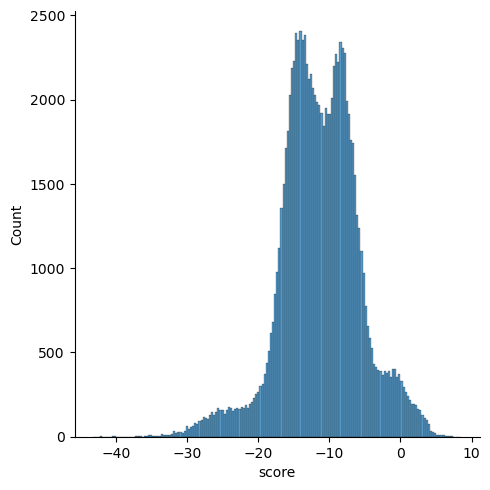

In [17]:
from scipy.special import logit

sns.displot(logit(df.score), kind='hist')

In [18]:
df['pymnt_sum'] = [x.sum().item() for x in df.pymnt]
df = df.join(s_sim_pymnts.rename('sim_pymnts_sum'))

In [19]:
df['score_qcut'] = pd.qcut(df.score, q=11)
df.groupby('score_qcut', observed=False)[['pymnt_sum', 'sim_pymnts_sum']].sum()

,pymnt_sum,sim_pymnts_sum
score_qcut,,
"(-0.0009999999999999998, 2.29e-08]",1.773596e+08,1.501851e+08
"(2.29e-08, 1.6e-07]",1.543493e+08,1.543862e+08
"(1.6e-07, 5.35e-07]",1.567431e+08,1.585157e+08
"(5.35e-07, 1.66e-06]",1.496564e+08,1.552077e+08
"(1.66e-06, 5.9e-06]",1.367595e+08,1.499193e+08
"(5.9e-06, 2.34e-05]",1.187432e+08,1.462232e+08
"(2.34e-05, 9.17e-05]",9.746922e+07,1.478556e+08
"(9.17e-05, 0.000298]",6.952818e+07,1.494230e+08
"(0.000298, 0.00113]",5.448790e+07,1.405301e+08
